<img src="CRISP-DM_Process_Diagram.png" width="30%" align="right">

# Legalese Detection and Rating

The first half of this notebook builds an NLP model trained on California Court Decisions to detect legalese. This is essentially a supervised binary classification problem, where the goal is to detect text resembling legalese.

The second half of this notebook takes the model and applies it to user timelines on Twitter. As expected, legal correspondents like NPR's Nina Totenberg score higher on the model than individuals who are not associated with the legal community.

This notebook is organized according to the Cross Industry Standard Process for Data Mining (CRISP-DM) framework:

https://en.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining

## POTENTIAL APPLICATIONS - User Segmentation

As shown below, the Model can be applied to any text, in this case Twitter user timelines, which show that the model can adequately detect and thus identify individuals who are most associated with the legal community. 

Thus, given other genres of text, we can build classification models to quickly assess text genres and as a results, group like-minded individuals. 

## DATA SOURCES

To train the NLP model, recent (June 2016) California Court Decisions were gathered and treated as the legalese text. To train the non-legalese portion, text from the Hunger Games and Harry Potter was used. Approximately 1 Million words from each class is gathered to build the models. 

## DATA PREPARATION

In [1]:
# Importing libraries to read PDF court documents
# SpaCy is a very-fast NLP parser in comparisong to python's NLTK and text-blob
import PyPDF2
import spacy
from spacy.en import English
from spacy import attrs
import numpy as np

parser = English()

### Loading court documents and non-legalese text. 
#### Assumptions:
 - California Supreme Court Decision Documents = Legalese (class: 1)
 - Hunger Games and Harry Potter Text = non-Legalese (class: 0)

In [2]:
pdfList = []
for i in range(1,26): #PDF files are named numberically, 1-26
    pdfList.append(str(i)+".PDF")

text = []
for pdf in pdfList:
    with open(pdf, 'rb') as pdfFileObj:
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        for page in range(1,pdfReader.getNumPages()):
            pageObj = pdfReader.getPage(page)
            text.append(pageObj.extractText())

docTrain1 = ' '.join(text) #combine all pages into a String doc
print ("Words in court documents:", len(docTrain1))

text = [] 
with open('HungerGames.pdf', 'rb') as pdfFileObj:
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    for page in range(1,pdfReader.getNumPages()):
        pageObj = pdfReader.getPage(page)
        text.append(pageObj.extractText())

with open('HarryPotter.pdf', 'rb') as pdfFileObj:
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    for page in range(1,pdfReader.getNumPages()):
        pageObj = pdfReader.getPage(page)
        text.append(pageObj.extractText())
        
docTrain0 = ' '.join(text) #combine all pages into a String doc
print ("Words in non-court documents:",len(docTrain0))

Words in court documents: 1067102
Words in non-court documents: 1004314


### We will build the NLP model at the sentence level. Meaning, each sentence will be evaluated as a unit to see if it is legalese or not. 

### Sentences are identified with the help of SpaCy

In [3]:
parsedData = parser(docTrain1)

#sents1 = legalese sentences 
#sents0 = non-legalese

sents1 = []
for span in parsedData.sents:
    sent = ''.join(parsedData[i].string for i in range(span.start, span.end)).strip()
    sents1.append(sent)
print ("Sentences in legalese text:",len(sents1))

parsedData = parser(docTrain0)

sents0 = []
for span in parsedData.sents:
    sent = ''.join(parsedData[i].string for i in range(span.start, span.end)).strip()
    sents0.append(sent)
print ("Sentences in non-legalese text:",len(sents0))

Sentences in legalese text: 8946
Sentences in non-legalese text: 17310


## MODELING

### Now that we have our sentences, we will begin building our NLP pipeline. A Linear Support Vector Machine will be employed as the binary classifier

The following site was referenced for portions of the code below:

https://nicschrading.com/project/Intro-to-NLP-with-spaCy/

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import string
import re

# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

In [5]:
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
        
    def get_params(self, deep=True):
        return {}

# A custom function to clean the text before sending it into the vectorizer, called by Transformer
def cleanText(text):
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()
    
    return text

# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    return tokens

### Defining the Training dataset

In [6]:
# define training data
train = sents1+sents0 #sents1 = legalese sentences, sents0 = non-legalese

labelsTrain = [] #labels must be associated with each sentence type for a supervised model
for i in range(0,len(train)):
    if (i < len(sents1)):
        labelsTrain.append(1) #appending label to sents1
    else:
        labelsTrain.append(0) #appending label to sents0

### Defining the Test dataset

In [7]:
# define test data
test = ["Plaintiffs failed to establish",
        "challenged statutes violate equal protection",
        "I just want to eat a hamburger", 
        "this is just another sentence", 
        "the quick brown fox jumped",
        "courts and statutes", 
        "over the lazy dog",
        "what time is the party",
        "what are my legal rights",
        "due process in civil court",
        "what time is it",
        "let's run to the park and have fun",
        "let's add come complexity to this sentence",
        "What would be a good test",
        "who in the world knows all about",
        "I will be getting home late today",
        "the plaintiff alleges that the defendant",
        "Three more sentences to go here",
        "let's hurry up so we can go home",
        "she went to court today and"]
labelsTest = [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

print ("Making sure the test sentences and labels match in size")
print (len(test),len(labelsTest))

Making sure the test sentences and labels match in size
20 20


### In the CountVectorizer step below, I use an ngram range of 1-4 since legal terms tend to appear together. 

In [8]:
# the vectorizer and classifer to use
# note that I changed the tokenizer in CountVectorizer to use a custom function using spaCy's tokenizer
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,4))
lsa = TruncatedSVD(100, algorithm = 'randomized')
clf = LinearSVC()
# the pipeline to clean, tokenize, vectorize, and classify
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer),('clf', clf)])

In [9]:
# train
pipe.fit(train, labelsTrain)

Pipeline(steps=[('cleanText', <__main__.CleanTextTransformer object at 0x180a1f240>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

## EVALUATION

### When we test our model below, we achieve an Accuracy of 95% using our Test Sentences. 

In [10]:
# test
preds = pipe.predict(test)

for (sample, pred) in zip(test, preds):
    print(sample, ":", pred)

print("\n","Accuracy:", accuracy_score(labelsTest, preds))

Plaintiffs failed to establish : 1
challenged statutes violate equal protection : 1
I just want to eat a hamburger : 0
this is just another sentence : 0
the quick brown fox jumped : 0
courts and statutes : 1
over the lazy dog : 0
what time is the party : 0
what are my legal rights : 0
due process in civil court : 1
what time is it : 0
let's run to the park and have fun : 0
let's add come complexity to this sentence : 0
What would be a good test : 0
who in the world knows all about : 0
I will be getting home late today : 0
the plaintiff alleges that the defendant : 1
Three more sentences to go here : 0
let's hurry up so we can go home : 0
she went to court today and : 1

 Accuracy: 0.95


## DEPLOYMENT

### GET TWITTER DATA

In [11]:
import pandas as pd
import tweepy
import json
import cnfg
from os.path import expanduser

home = expanduser("~")
config = cnfg.load(home + "/.twitter_config")

auth = tweepy.OAuthHandler(config["consumer_key"],
                           config["consumer_secret"])
auth.set_access_token(config["access_token"],
                      config["access_token_secret"])

api=tweepy.API(auth)

### Defining several functions to clean Twitter text

In [12]:
def structure_results(results, handle):
    id_list = [tweet.id for tweet in results]
    data = pd.DataFrame(id_list,columns=['id'])
    
    data["Handle"] = handle
    data["Text"] = [tweet.text for tweet in results]
    data["Datetime"] = [tweet.created_at for tweet in results]
    data["Location"] = [tweet.place for tweet in results]
    
    return data

# Replace https...with empty string
def httpRemove(text):
    if re.search('https?:\/\/.*[\r\n]*', text):
        return re.sub('https?:\/\/.*[\r\n]*', '', text).strip()
    else:
        return text

# Replace @.... with empty string
def atRemove(text):
    if re.search('@([\w.-]+)', text):
        return re.sub('@([\w.-]+)', '', text).strip()
    else:
        return text

# Replace #.... with empty string
def hashRemove(text):
    if re.search('#([\w.-]+)', text):
        return re.sub('#([\w.-]+)', '', text).strip()
    else:
        return text

def toPandas(userText, preds):
    id_list=[i for i in range(0,len(preds))]
    data=pd.DataFrame(id_list,columns=['tweet_id'])
    
    data["text"]= [tweet for tweet in userText]
    data["Prediction"] = [prediction for prediction in preds]

    return data

### The following code gathers all timeline history for each of the users in the handles list.

In [ ]:
import time
handles = ['NinaTotenberg', 'justinbieber', 'LeoDiCaprio', 'espn','EricHolder','Snowden','jimmykimmel','realDonaldTrump']
#handles = ['NinaTotenberg']

frames = []
for handle in handles:
    tweets = tweepy.Cursor(api.user_timeline,id=handle).items(1000)
    results = []
    print (handle)
    for tweet in tweets:
        results.append(tweet)
    
    data = structure_results(results, handle)
    frames.append(data)
    time.sleep(1)

### We transfer all tweets into a pandas dataframe and perform some text cleaning

In [14]:
alldata = pd.concat(frames)

alldata["text_no_https"] = alldata.Text.apply(httpRemove)

alldata["text_no_https_at"] = alldata.text_no_https.apply(atRemove)

alldata["text_no_https_at_hash"] = alldata.text_no_https_at.apply(hashRemove)

userText = []
for text in alldata.text_no_https_at_hash:
    userText.append(text)

### We apply the model to each tweet to determine its classification, we then normalize each user's results by their total number of tweets to achieve a 'Legalese Score'. 

### The higher the ratio, the larger the percentage of tweets that are characterized as legalese.

In [15]:
# test
preds = pipe.predict(userText)

alldata['Prediction'] = [p for p in preds]

pd.set_option('max_colwidth', 120)

alldata['Rating'] = 0
for handle in alldata.Handle.unique():
    rating = alldata[alldata['Handle'] == handle].Prediction.sum()/alldata[alldata['Handle'] == handle].Prediction.count()
    print (handle, rating)
    alldata.loc[alldata['Handle'] == handle,'Rating'] = rating

NinaTotenberg 0.440823327616
justinbieber 0.148
LeoDiCaprio 0.177068214804
espn 0.215
EricHolder 0.354166666667
Snowden 0.274


Sample View of the Tweets dataframe

In [19]:
alldata.sample(frac = 0.1).head(10)

,id,Handle,Text,Datetime,Location,text_no_https,text_no_https_at,text_no_https_at_hash,Prediction,Rating
254,590886205916651520,LeoDiCaprio,RT @guildnavigator: Let's be in awe of what we have. Let's look after it. Happy #EarthDay #EarthDay2015 #EarthDayEve...,2015-04-22 14:33:44,None,RT @guildnavigator: Let's be in awe of what we have. Let's look after it. Happy #EarthDay #EarthDay2015 #EarthDayEve...,RT : Let's be in awe of what we have. Let's look after it. Happy #EarthDay #EarthDay2015 #EarthDayEveryDay,RT : Let's be in awe of what we have. Let's look after it. Happy,0,0.177068
182,641728093577695233,LeoDiCaprio,. @IanAD57 I hope you will join with me in standing for clean air and #ActOnClimate. Yes on #SB350 and #SB32.,2015-09-09 21:41:14,None,. @IanAD57 I hope you will join with me in standing for clean air and #ActOnClimate. Yes on #SB350 and #SB32.,. I hope you will join with me in standing for clean air and #ActOnClimate. Yes on #SB350 and #SB32.,. I hope you will join with me in standing for clean air and Yes on and,0,0.177068
222,725347851056750593,Snowden,Coming soon to the list of items banned in federal buildings: https://t.co/hHsVOtqq59,2016-04-27 15:36:18,None,Coming soon to the list of items banned in federal buildings:,Coming soon to the list of items banned in federal buildings:,Coming soon to the list of items banned in federal buildings:,0,0.274000
513,327472154423726080,NinaTotenberg,I'll do anything for #npr http://t.co/nOKYVh98pC,2013-04-25 17:20:20,None,I'll do anything for #npr,I'll do anything for #npr,I'll do anything for,0,0.440823
628,750007192808525824,espn,Warriors: Just the third team in the past 50 years to have 3 of the NBA's top 12 scorers from the previous season. h...,2016-07-04 16:43:43,None,Warriors: Just the third team in the past 50 years to have 3 of the NBA's top 12 scorers from the previous season.,Warriors: Just the third team in the past 50 years to have 3 of the NBA's top 12 scorers from the previous season.,Warriors: Just the third team in the past 50 years to have 3 of the NBA's top 12 scorers from the previous season.,1,0.215000
735,672998113213198336,justinbieber,RT @officialcharts: .@JustinBieber has replaced HIMSELF at No.1 on the Official Singles Chart with Love Yourself htt...,2015-12-05 04:37:08,None,RT @officialcharts: .@JustinBieber has replaced HIMSELF at No.1 on the Official Singles Chart with Love Yourself,RT : . has replaced HIMSELF at No.1 on the Official Singles Chart with Love Yourself,RT : . has replaced HIMSELF at No.1 on the Official Singles Chart with Love Yourself,0,0.148000
107,684510211487457284,LeoDiCaprio,RT @wef: Where are food supplies most at risk from #climatechange? https://t.co/8ZexSNkjGn #foodsecurity https://t.c...,2016-01-05 23:02:06,None,RT @wef: Where are food supplies most at risk from #climatechange?,RT : Where are food supplies most at risk from #climatechange?,RT : Where are food supplies most at risk from ?,0,0.177068
453,751890348847210496,espn,"Under 24 hours to the #Euro2016 final (3 p.m. ET, ESPN/WatchESPN). But today in Paris, @s3society put on the show. h...",2016-07-09 21:26:43,None,"Under 24 hours to the #Euro2016 final (3 p.m. ET, ESPN/WatchESPN). But today in Paris, @s3society put on the show.","Under 24 hours to the #Euro2016 final (3 p.m. ET, ESPN/WatchESPN). But today in Paris, put on the show.","Under 24 hours to the final (3 p.m. ET, ESPN/WatchESPN). But today in Paris, put on the show.",1,0.215000
897,667064009820999680,justinbieber,Playing more new tracks from #purpose on @CapitalOfficial now. Listen - https://t.co/7wod0j2Afe #BieberOnCapital ht...,2015-11-18 19:37:08,None,Playing more new tracks from #purpose on @CapitalOfficial now. Listen -,Playing more new tracks from #purpose on now. Listen -,Playing more new tracks from on now. Listen -,0,0.148000
257,721399251679461376,Snowden,"RT @ggreenwald: If your opponent makes less in a year than you made in one 45-minute speech to Goldman, maybe don't ...",2016-04-16 18:05:5

In [20]:
#pickling the results for flask integration
alldata.to_pickle('test')

## RESULTS SUMMARY

In summary, the NLP model was able to rank Nina Totenberg highest and Justin Bieber with the lowest score. This is an indication that the model is working as expected. 

In [38]:
idList = []
r = []
for handle in alldata.Handle.unique():
    idList.append(handle)
    r.append(alldata[alldata['Handle'] == handle].Rating[0])

smallDataframe = pd.DataFrame(idList,columns=['Handle'])
smallDataframe["Rating"] = r

smallDataframe = smallDataframe.sort_values(by='Rating',ascending=False)

#pickling the results for flask integration
smallDataframe.to_pickle('summary')

smallDataframe

,Handle,Rating
0,NinaTotenberg,0.440823
4,EricHolder,0.354167
5,Snowden,0.274000
3,espn,0.215000
2,LeoDiCaprio,0.177068
1,justinbieber,0.148000


### The barchart below displays the above rankings graphically. 

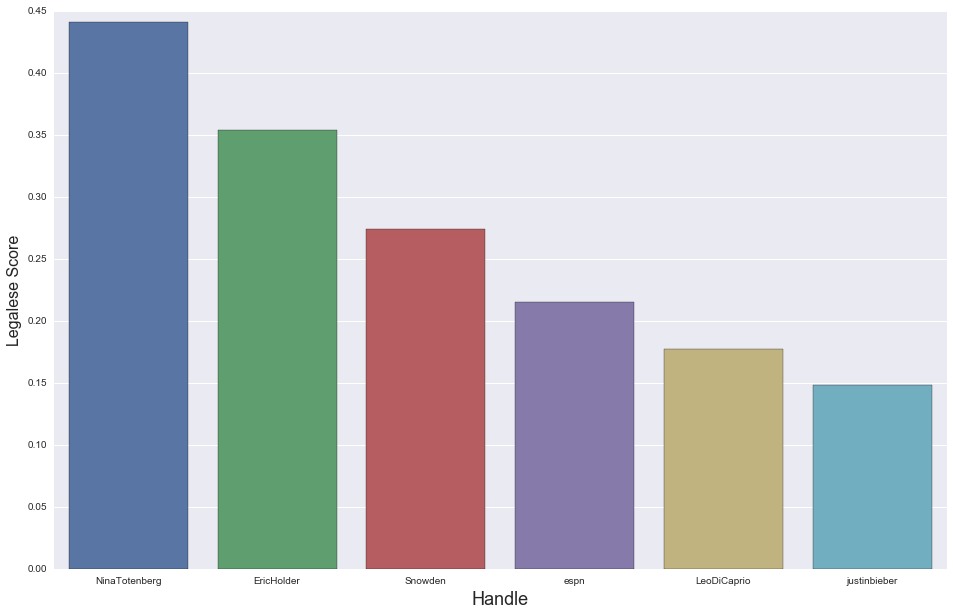

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(16,10))

sns.barplot(smallDataframe['Handle'],smallDataframe['Rating'])

plt.xlabel('Handle', fontsize=18)
plt.ylabel('Legalese Score', fontsize=16)
plt.show()